In [1]:
# --- Core libraries ---
import os
import math
import random
import time
import numpy as np

# --- Data handling ---
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from dataclasses import dataclass, field
from sklearn.preprocessing import label_binarize

# --- PyTorch ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchaudio.functional import bandpass_biquad

# --- Audio processing ---
import torchaudio
import torchaudio.transforms as T

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
from tqdm.notebook import tqdm
import torchvision
from torchvision.ops.focal_loss import sigmoid_focal_loss
import cv2

# --- Parallel and Custom Tools ---
from joblib import Parallel, delayed
from torch.amp import GradScaler, autocast
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import Optional, List, Tuple
import timm
import tempfile
import gc
import itertools

In [35]:
@dataclass
class CFG:
    # General
    LOAD_DATA: bool = True
    seed: int = 69
    debug: bool = False
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    ## Data paths ##
    OUTPUT_DIR: str = '/kaggle/working/'
    temporary_dir: str = field(init=False)
    spectrogram_dir: str = "/kaggle/input/eda-birdclef2025" #"/kaggle/working/precomputed_spectrograms"
    spectrogram_csv_filename: str = "spec_metadata.csv"
    spectrograms_metadata_path: str = field(init=False) # "filename", "primary_label"
    pseudo_spectrogram_dir: str = "/kaggle/working/"
    pseudo_spectrogram_csv_filename: str = "pseudo_metadata.csv"
    pseudo_spectrograms_metadata_path: str = field(init=False) # "filename", "primary_label"
    
    # Base path to dataset
    data_path: str = '/kaggle/input/birdclef-2025/'
    # Key file paths
    metadata_path: str = field(init=False)
    taxonomy_path: str = field(init=False)
    sample_submission_path: str = field(init=False)
    location_path: str = field(init=False)
    # Audio data directories
    train_data_path: str = field(init=False)
    test_soundscapes_path: str = field(init=False)
    unlabeled_soundscapes_path: str = field(init=False)

    # Audio config
    topDB: int = 80
    FS: int = 32000
    CHUNK_LENGTH: float = 5.0   # seconds
    N_FFT: int = 1024
    HOP_LENGTH: int = 512
    N_MELS: int = 128
    FMIN: int = 50
    FMAX: int = 16000
    POWER: int = 2
    SPEC_DTYPE: str = 'float16'  # for disk saving
    spectrogram_time_frames: int = field(init=False)
    
    # VAD and Filtering
    VAD_ENABLED: bool = False  # Whether to apply Voice Activity Detection
    VAD_THRESHOLD: float = 0.4  # Confidence threshold for Silero VAD
    BANDPASS_LOW: int = 300
    BANDPASS_HIGH: int = 16000
    VISUALIZE_SKIPPED: bool = False  # Set to True to see spectrograms of skipped chunks


    # Training
    BATCH_SIZE: int = 32
    EPOCHS: int = 20
    criterion: str = 'BCEWithLogitsLoss'
    optimizer: str = 'AdamW'
    LEARNING_RATE: float = 1e-3
    weight_decay: float = 1e-5
    scheduler: str = 'CosineAnnealingLR'
    min_lr: float = 1e-6
    n_fold: int = 5
    num_workers: int = 4

    # Augmentation
    augment = True
    aug_prob: float = 0.5
    mixup_alpha: float = 0.4

    # Model
    model_name: str = "efficientnet_b0" # 'efficientnet_b3_pruned', 'efficientnetv2_rw_m', 'efficientvit_l1', 'efficientvit_l2', 'efficientvit_m0'
    pretrained: bool = True
    in_channels: int = 1
    input_directory: str = '/kaggle/input'
    input_model_filename: str = field(init=False)
    output_model_filename: str = field(init=False)
    pretrained_model_weights: str = field(init=False)
    sed_model_weights_path: str = field(init=False)
    num_classes: str = field(init=False)

    # Focal Loss parameters
    alpha: float = 0.25 
    gamma: float = 2.0 
    reduction: str = "mean"
    bce_weight: float = 1.0
    focal_weight: float = 1.0
    secondary_weight: float = .5

    def __post_init__(self):
        self.metadata_path = os.path.join(self.data_path, 'train.csv')
        self.taxonomy_path = os.path.join(self.data_path, 'taxonomy.csv')
        self.sample_submission_path = os.path.join(self.data_path, 'sample_submission.csv')
        self.location_path = os.path.join(self.data_path, 'recording_location.txt')
        self.train_data_path = os.path.join(self.data_path, 'train_audio')
        self.test_soundscapes_path = os.path.join(self.data_path, 'test_soundscapes')
        self.unlabeled_soundscapes_path = os.path.join(self.data_path, 'train_soundscapes')
        self.spectrograms_metadata_path = os.path.join(self.spectrogram_dir, self.spectrogram_csv_filename)
        self.pseudo_spectrograms_metadata_path = os.path.join(self.pseudo_spectrogram_dir, self.pseudo_spectrogram_csv_filename)
        
        self.input_model_filename = f'{self.model_name}_pretrained.pth'
        self.output_model_filename = f'{self.model_name}_sed.pth'
        self.pretrained_model_weights = os.path.join(self.input_directory, "offline-packages", self.input_model_filename)
        self.sed_model_weights_path = os.path.join(self.input_directory, "effnet14", self.output_model_filename)
        self.num_classes = len(pd.read_csv(self.taxonomy_path))

        self.temporary_dir = tempfile.TemporaryDirectory().name
        self.spectrogram_time_frames = int((self.FS * self.CHUNK_LENGTH) // self.HOP_LENGTH + 1)
        if self.debug:
            self.EPOCHS = 2
            print("⚠️ Debug mode is ON. Training only for 2 epochs.")

cfg = CFG()

In [3]:
class PseudoLabeler:
    """
    Generates pseudo-labels from a trained model over unlabeled soundscape audio.
    
    Outputs:
    - Spectrogram .npy files (preprocessed chunks)
    - CSV file with filename and pseudo-label probabilities
    """
    def __init__(self, model, cfg):
        self.model = model.eval().to(cfg.device)
        self.cfg = cfg
        self.chunk_samples = int(cfg.CHUNK_LENGTH * cfg.FS)

        # Preprocessing transforms
        self.mel_transform = T.MelSpectrogram(
            sample_rate=cfg.FS,
            n_fft=cfg.N_FFT,
            hop_length=cfg.HOP_LENGTH,
            n_mels=cfg.N_MELS,
            f_min=cfg.FMIN,
            f_max=cfg.FMAX,
            power=cfg.POWER
        )
        self.db_transform = T.AmplitudeToDB(top_db=cfg.topDB)

        # Output dir
        self.output_dir = os.path.join(cfg.OUTPUT_DIR, "pseudo_spectrograms")
        os.makedirs(self.output_dir, exist_ok=True)

    def process_directory(self, input_dir):
        """
        Process all audio files in a directory, outputting pseudo-labeled spectrograms + CSV.
        """
        audio_filenames = sorted(os.listdir(input_dir))
        audio_filepaths = [os.path.join(input_dir, fname) for fname in audio_filenames if fname.endswith(".ogg")]
        
        all_data = Parallel(n_jobs=self.cfg.num_workers)(
            delayed(self.process_file)(f) for f in tqdm(audio_filepaths, desc="Pseudo-labeling files")
        )
        
        # Flatten the list of lists
        all_data = [item for sublist in all_data if sublist is not None for item in sublist]

        # Save to CSV
        df = pd.DataFrame(all_data)
        out_csv_path = os.path.join(self.cfg.OUTPUT_DIR, "pseudo_metadata.csv")
        df.to_csv(out_csv_path, index=False)
        print(f"[INFO] Pseudo-labeling complete. Metadata saved to: {out_csv_path}")
    

    def process_file(self, audio_path):
        """
        Process a single audio file → chunk → spectrogram → model → save + collect metadata.
        """
        waveform, sr = torchaudio.load(audio_path)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)  # mono

        chunks = self._chunk_waveform(waveform)
        results = []

        for idx, chunk in enumerate(chunks):
            spec = self._waveform_to_spec(chunk)
            pred = self._predict(spec)

            # Save spectrogram
            base_name = os.path.basename(audio_path).replace(".ogg", "")
            chunk_fname = f"{base_name}_chunk_{idx}.npy"
            np.save(os.path.join(self.output_dir, chunk_fname), spec.numpy().astype(self.cfg.SPEC_DTYPE))

            # Save row: filename + soft targets
            row = {"filename": chunk_fname}
            for i, p in enumerate(pred):
                row[f"class_{i}"] = float(p)
            results.append(row)

        return results

    def _chunk_waveform(self, waveform):
        """
        Slice audio into overlapping 5-second chunks.
        """
        chunks = []
        total_samples = waveform.shape[-1]
        stride = self.chunk_samples // 2  # 50% overlap

        for start in range(0, total_samples - self.chunk_samples + 1, stride):
            end = start + self.chunk_samples
            chunk = waveform[..., start:end]
            if chunk.shape[-1] < self.chunk_samples:
                continue
            chunks.append(chunk)

        return chunks

    def _waveform_to_spec(self, waveform):
        """
        Convert waveform to normalized log-mel spectrogram.
        """
        with torch.no_grad():
            mel = self.mel_transform(waveform)
            log_mel = self.db_transform(mel)
            norm_spec = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-6)
        return norm_spec.squeeze(0)  # [M, T]


    def _predict(self, spec):
        """
        Run model prediction on one spectrogram → soft targets.
        """
        self.model.eval()
        with torch.no_grad():
            # Prepare tensor [1, 3, M, T]
            tensor = spec.unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1).to(self.cfg.device)
            logits = self.model(tensor)
            probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()
        return probs

In [ ]:
class EfficientNetFrequencySED(nn.Module):
    """
    EfficientNet with a custom SED head for frequency-wise attention.
    
    This model:
    - Uses a pretrained EfficientNet backbone
    - Applies a frequency-wise attention mechanism
    - Outputs class probabilities for multi-class classification
    
    Arguments:
    ----------
    cfg : object
        Configuration object (assumes it's an instance of CFG)
    """
    def __init__(self, cfg):
        super().__init__()
        
        # Store config and device
        self.cfg = cfg
        self.device = torch.device(cfg.device)

        # Create model with the correct architecture
        self.backbone = timm.create_model(cfg.model_name, pretrained=cfg.pretrained)

        # Remove classifier head, we will add our own
        self.feature_dim = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()  # Remove classifier

        # Frequency-wise attention block -> attention mechanism to emphasize important frequency regions.
        self.att_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((None, 1)),          # Mean over frequency bands
            nn.Conv2d(self.feature_dim, self.feature_dim, kernel_size=1),
            nn.Sigmoid()
        )

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Conv2d(self.feature_dim, cfg.num_classes, kernel_size=1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        """
        Forward pass of the model.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape [B, 3, M, T], where:
            - B = Batch size
            - M = Mel bands (frequency bins)
            - T = Time frames

        Returns:
        --------
        torch.Tensor:
            Output tensor of shape [B, num_classes]
        """
        x = x.to(self.device)
        features = self.backbone.forward_features(x)  # EfficientNet backbone [B, C, M', T']
        attn = self.att_block(features)  # Attention on frequency bands [B, C, T', 1]
        features = features * attn       # Apply attention
        
        out = self.classifier(features)  # Classify [B, num_classes]
        return out


def model_predict_fn(spec_tensor: torch.Tensor) -> torch.Tensor:
    """
    Runs inference on a single spectrogram and returns per-class probabilities.
    Expects input shape [1, 3, M, T].
    """
    model.eval()
    with torch.no_grad(), autocast(device_type=cfg.device):
        outputs = model(spec_tensor.to(cfg.device))
        probs = torch.sigmoid(outputs)
    return probs.squeeze(0).cpu()
    
# === Load your trained model ===
model = EfficientNetFrequencySED(cfg)


In [5]:
# Load trained model /kaggle/input/effnet14
pseudo_model = EfficientNetSED(cfg)
pseudo_model.load_state_dict(torch.load(cfg.sed_model_weights_path, map_location=cfg.device))

# Init and run pseudo-labeler
labeler = PseudoLabeler(pseudo_model, cfg)
labeler.process_directory(cfg.unlabeled_soundscapes_path)


[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b0_pretrained.pth


Pseudo-labeling files:   0%|          | 0/9726 [00:00<?, ?it/s]

[INFO] Pseudo-labeling complete. Metadata saved to: /kaggle/working/pseudo_metadata.csv


[INFO] Loading pseudo-labels from: /kaggle/working/pseudo_metadata.csv
[OK] Correct number of columns (207)

[INFO] Summary statistics of predicted probabilities:
           class_0       class_1       class_2       class_3       class_4  \
min   7.067272e-08  1.391113e-07  8.241713e-09  1.255786e-09  4.273285e-07   
max   1.139583e-01  2.920220e-01  2.408340e-01  4.065042e-01  9.690908e-01   
mean  2.764014e-03  5.363178e-03  3.396002e-03  6.817977e-04  8.941750e-03   
std   4.912837e-03  1.044162e-02  6.961680e-03  5.186297e-03  2.639629e-02   

           class_5   class_6       class_7       class_8       class_9  ...  \
min   6.515533e-08  0.000003  2.435017e-07  9.119215e-07  4.782528e-09  ...   
max   5.931756e-01  0.888864  2.281107e-01  4.248131e-01  1.698010e-01  ...   
mean  1.257508e-02  0.032083  4.416458e-03  1.403579e-02  6.360371e-03  ...   
std   2.245111e-02  0.062687  8.259831e-03  2.304367e-02  1.292972e-02  ...   

      class_196  class_197  class_198  class_199  

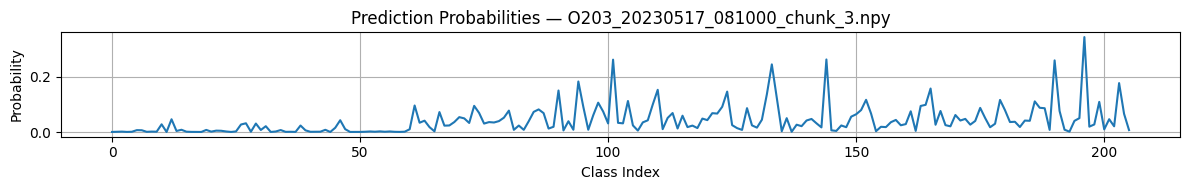

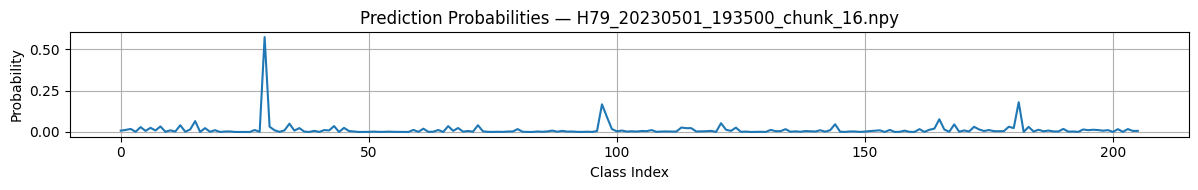

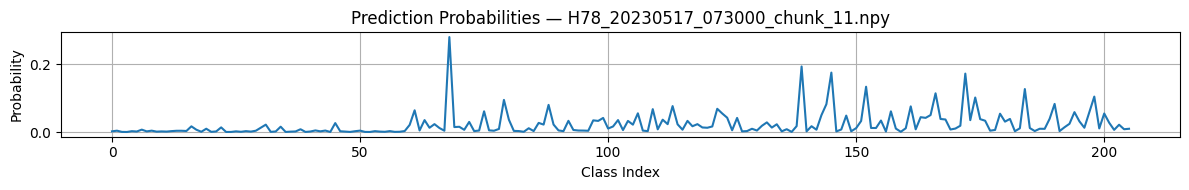

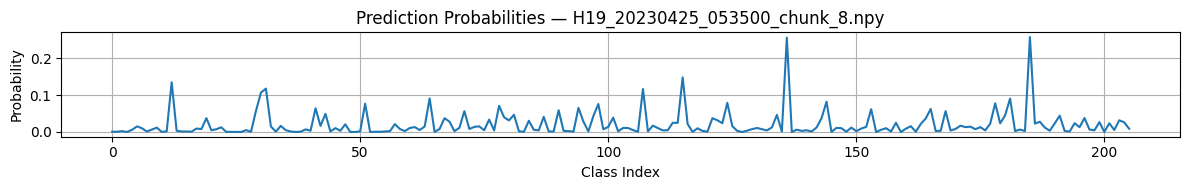

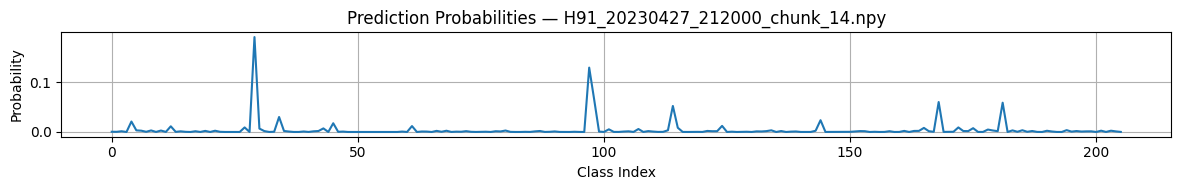

In [6]:
def validate_pseudo_labels(csv_path, num_classes=206, max_rows_to_check=5):
    """
    Basic health checks for the generated pseudo-labels.
    
    Parameters:
    -----------
    csv_path : str
        Path to the pseudo_metadata.csv file
    num_classes : int
        Number of species classes (default = 206)
    max_rows_to_check : int
        How many sample predictions to inspect visually
    """
    print(f"[INFO] Loading pseudo-labels from: {csv_path}")
    if not os.path.exists(csv_path):
        print(f"[ERROR] File not found: {csv_path}")
        return
    
    df = pd.read_csv(csv_path)

    # 1. Check shape
    expected_cols = 1 + num_classes  # filename + class_*
    if df.shape[1] != expected_cols:
        print(f"[ERROR] Expected {expected_cols} columns, got {df.shape[1]}")
        return
    else:
        print(f"[OK] Correct number of columns ({df.shape[1]})")

    # 2. Check NaNs or constant rows
    if df.isnull().values.any():
        print("[WARNING] NaNs found in the pseudo-labels!")
    if (df.drop(columns=['filename']).nunique(axis=1) == 1).any():
        print("[WARNING] Some rows have constant predictions (e.g., all zeros or ones)")

    # 3. Basic statistics
    pred_cols = [c for c in df.columns if c.startswith("class_")]
    stats = df[pred_cols].describe()
    print("\n[INFO] Summary statistics of predicted probabilities:")
    print(stats.loc[["min", "max", "mean", "std"]])

    # 4. Visual inspection
    print("\n[INFO] Visualizing soft predictions for random chunks:")
    sample = df.sample(n=min(max_rows_to_check, len(df)), random_state=42)
    for idx, row in sample.iterrows():
        values = row[pred_cols].values.astype(np.float32)
        plt.figure(figsize=(12, 2))
        plt.plot(values)
        plt.title(f"Prediction Probabilities — {row['filename']}")
        plt.xlabel("Class Index")
        plt.ylabel("Probability")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


validate_pseudo_labels("/kaggle/working/pseudo_metadata.csv", num_classes=cfg.num_classes)


In [44]:
class PseudoLabeledDataset(Dataset):
    """
    Dataset for pseudo-labeled spectrograms with flexible filtering strategies.

    Supports:
    - "none": raw soft labels
    - "hard": hard thresholding
    - "topk": top-k masking
    - "hybrid": combine hard and soft
    - callable: pass a function(labels: np.ndarray) -> np.ndarray
    """
    def __init__(self, metadata_csv, spec_dir, strategy="none", soft_threshold=0.5, hard_threshold=0.8, top_k=1, index_to_label=None):
        self.df = pd.read_csv(metadata_csv)
        self.spec_dir = spec_dir
        self.strategy = strategy
        self.soft_threshold = soft_threshold
        self.hard_threshold = hard_threshold
        self.top_k = top_k
        self.label_cols = [c for c in self.df.columns if c.startswith("class_")]
        self.num_classes = len(self.label_cols)
        self.index_to_label = index_to_label or {i: f"class_{i}" for i in range(self.num_classes)}
        self.filter_fn = strategy if callable(strategy) else None
        
        # Precompute label stats on filtered labels
        self._label_summary = self._compute_label_summary()


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        spec_path = os.path.join(self.spec_dir, row["filename"])
        spec = np.load(spec_path).astype(np.float32)
        spec = torch.tensor(spec).unsqueeze(0).repeat(3, 1, 1)

        labels = row[self.label_cols].values.astype(np.float32)

        # Handle strategy
        if self.filter_fn:
            labels = self.filter_fn(labels)

        elif self.strategy == "hard":
            labels = (labels >= self.hard_threshold).astype(np.float32)

        elif self.strategy == "topk":
            topk_idx = labels.argsort()[-self.top_k:]
            mask = np.zeros_like(labels)
            mask[topk_idx] = 1.0
            labels = mask.astype(np.float32)

        elif self.strategy == "hybrid":
            soft_mask = ((labels > self.soft_threshold) & (labels < self.hard_threshold)).astype(np.float32)
            hard_mask = (labels >= self.hard_threshold).astype(np.float32)
            labels = labels * soft_mask + 1.0 * hard_mask

        # else: strategy == "none", keep raw labels

        return {
            "spectrogram": spec,
            "labels": torch.tensor(labels, dtype=torch.float32),
            "filename": row["filename"]
        }

    def _compute_label_summary(self, sample_size=500):
        """
        Samples and summarizes the distribution of label values after filtering.
        """
        summary = {
            "total_samples": len(self.df),
            "avg_labels_per_sample": 0,
            "hard_ones": 0,
            "soft_values": 0,
            "zeros": 0
        }

        sample_indices = np.random.choice(len(self.df), size=min(sample_size, len(self.df)), replace=False)
        label_counts = []

        for idx in sample_indices:
            row = self.df.iloc[idx]
            labels = row[self.label_cols].values.astype(np.float32)

            if self.filter_fn:
                labels = self.filter_fn(labels)
            elif self.strategy == "hard":
                labels = (labels >= self.hard_threshold).astype(np.float32)
            elif self.strategy == "topk":
                topk_idx = labels.argsort()[-self.top_k:]
                mask = np.zeros_like(labels)
                mask[topk_idx] = 1.0
                labels = mask.astype(np.float32)
            elif self.strategy == "hybrid":
                soft_mask = ((labels > self.soft_threshold) & (labels < self.hard_threshold)).astype(np.float32)
                hard_mask = (labels >= self.hard_threshold).astype(np.float32)
                labels = labels * soft_mask + 1.0 * hard_mask

            hard = np.sum(labels == 1.0)
            soft = np.sum((labels > 0) & (labels < 1.0))
            zeros = np.sum(labels == 0.0)

            label_counts.append(hard + soft)
            summary["hard_ones"] += hard
            summary["soft_values"] += soft
            summary["zeros"] += zeros

        summary["avg_labels_per_sample"] = np.mean(label_counts)
        summary["hard_ones"] = int(summary["hard_ones"])
        summary["soft_values"] = int(summary["soft_values"])
        summary["zeros"] = int(summary["zeros"])

        # Class-wise activations
        class_stats = {f"class_{i}": {"hard": 0, "soft": 0, "total": 0} for i in range(self.num_classes)}

        for idx in sample_indices:
            row = self.df.iloc[idx]
            labels = row[self.label_cols].values.astype(np.float32)

            if self.filter_fn:
                labels = self.filter_fn(labels)
            elif self.strategy == "hard":
                labels = (labels >= self.hard_threshold).astype(np.float32)
            elif self.strategy == "topk":
                topk_idx = labels.argsort()[-self.top_k:]
                mask = np.zeros_like(labels)
                mask[topk_idx] = 1.0
                labels = mask.astype(np.float32)
            elif self.strategy == "hybrid":
                soft_mask = ((labels > self.soft_threshold) & (labels < self.hard_threshold)).astype(np.float32)
                hard_mask = (labels >= self.hard_threshold).astype(np.float32)
                labels = labels * soft_mask + 1.0 * hard_mask

            for i, val in enumerate(labels):
                if val >= 1.0:
                    class_stats[f"class_{i}"]["hard"] += 1
                elif val > 0.0:
                    class_stats[f"class_{i}"]["soft"] += 1
                if val > 0.0:
                    class_stats[f"class_{i}"]["total"] += 1

        summary["class_stats"] = class_stats

        return summary

    def __repr__(self):
        s = f"PseudoLabeledDataset(strategy='{self.strategy}', size={len(self)}, classes={self.num_classes})"
        s += "\n\n  Label Summary (approx. over sample):"
        for k, v in self._label_summary.items():
            if k != "class_stats":
                s += f"\n    {k}: {v}"

        p = "No thresholds"
        if self.strategy=="hybrid":
            p = f"hard {self.hard_threshold} + soft {self.soft_threshold}"
        elif self.strategy=="topk":
            p = f"topk = {self.top_k}"
        elif self.strategy=="hard":
            p = f"hard {self.hard_threshold}"
            
        s += f"\n\n  Per-Class Activations ({p}):"
        stats = self._label_summary["class_stats"]
        # Show top 10 most frequent
        s += "\n    Top 10 most frequent species:"
        n=10
        most_frequent_stats = sorted(stats.items(), key=lambda x: x[1]["total"], reverse=True)[:n]
        for k, v in most_frequent_stats:
            label_name = self.index_to_label.get(int(k.replace("class_", "")), k)
            s += f"\n      {label_name}: total={v['total']}, hard={v['hard']}, soft={v['soft']}"

        # Show top 10 less frequent
        s += "\n    Top 10 less frequent species:"
        n=10
        less_frequent_stats = sorted(stats.items(), key=lambda x: x[1]["total"], reverse=False)[:n]
        for k, v in less_frequent_stats:
            label_name = self.index_to_label.get(int(k.replace("class_", "")), k)
            s += f"\n      {label_name}: total={v['total']}, hard={v['hard']}, soft={v['soft']}"
        return s

def get_index_to_label(cfg):
    taxonomy_df = pd.read_csv(cfg.taxonomy_path)
    label_to_index = {label: idx for idx, label in enumerate(sorted(taxonomy_df['primary_label'].unique()))}
    index_to_label = {v: k for k, v in label_to_index.items()}
    return index_to_label

In [38]:
dataset = PseudoLabeledDataset(
    metadata_csv="/kaggle/working/pseudo_metadata.csv",
    spec_dir="/kaggle/working/pseudo_spectrograms",
    strategy="hybrid",    # "none", "hard", "topk", "hybrid"
    soft_threshold=0.05, 
    hard_threshold=0.25,
    top_k=2,
    index_to_label=get_index_to_label(cfg)
)

print(dataset)
loader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.num_workers)


PseudoLabeledDataset(strategy='hybrid', size=223698, classes=206)

  Label Summary (approx. over sample):
    total_samples: 223698
    avg_labels_per_sample: 21.936
    hard_ones: 509
    soft_values: 10459
    zeros: 92032

  Per-Class Activations (hard 0.25 + soft 0.05):
    Top 10 most frequent species:
      compot1: total=323, hard=62, soft=261
      roahaw: total=321, hard=32, soft=289
      trsowl: total=304, hard=41, soft=263
      speowl1: total=298, hard=62, soft=236
      compau: total=284, hard=13, soft=271
      48124: total=280, hard=82, soft=198
      littin1: total=228, hard=3, soft=225
      tropar: total=206, hard=2, soft=204
      yeofly1: total=196, hard=1, soft=195
      whtdov: total=190, hard=10, soft=180
    Top 10 less frequent species:
      1139490: total=0, hard=0, soft=0
      126247: total=0, hard=0, soft=0
      21116: total=0, hard=0, soft=0
      22333: total=0, hard=0, soft=0
      24272: total=0, hard=0, soft=0
      24322: total=0, hard=0, soft=0
  

In [40]:
dataset = PseudoLabeledDataset(
    metadata_csv="/kaggle/working/pseudo_metadata.csv",
    spec_dir="/kaggle/working/pseudo_spectrograms",
    strategy="topk",    # "none", "hard", "topk", "hybrid"
    top_k=1,
    index_to_label=get_index_to_label(cfg)
)

print(dataset)
loader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.num_workers)


PseudoLabeledDataset(strategy='topk', size=223698, classes=206)

  Label Summary (approx. over sample):
    total_samples: 223698
    avg_labels_per_sample: 1.0
    hard_ones: 500
    soft_values: 0
    zeros: 102500

  Per-Class Activations (hard 0.8 + soft 0.5):
    Top 10 most frequent species:
      48124: total=94, hard=94, soft=0
      speowl1: total=57, hard=57, soft=0
      roahaw: total=49, hard=49, soft=0
      compot1: total=46, hard=46, soft=0
      trsowl: total=27, hard=27, soft=0
      21211: total=14, hard=14, soft=0
      64862: total=13, hard=13, soft=0
      50186: total=12, hard=12, soft=0
      whtdov: total=11, hard=11, soft=0
      52884: total=10, hard=10, soft=0
    Top 10 less frequent species:
      1139490: total=0, hard=0, soft=0
      1192948: total=0, hard=0, soft=0
      1194042: total=0, hard=0, soft=0
      126247: total=0, hard=0, soft=0
      1462711: total=0, hard=0, soft=0
      1462737: total=0, hard=0, soft=0
      1564122: total=0, hard=0, soft=

In [45]:
dataset = PseudoLabeledDataset(
    metadata_csv="/kaggle/working/pseudo_metadata.csv",
    spec_dir="/kaggle/working/pseudo_spectrograms",
    strategy="topk",    # "none", "hard", "topk", "hybrid"
    top_k=3,
    index_to_label=get_index_to_label(cfg)
)

print(dataset)
loader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.num_workers)


PseudoLabeledDataset(strategy='topk', size=223698, classes=206)

  Label Summary (approx. over sample):
    total_samples: 223698
    avg_labels_per_sample: 3.0
    hard_ones: 1500
    soft_values: 0
    zeros: 101500

  Per-Class Activations (topk = 3):
    Top 10 most frequent species:
      compot1: total=157, hard=157, soft=0
      speowl1: total=145, hard=145, soft=0
      48124: total=140, hard=140, soft=0
      trsowl: total=130, hard=130, soft=0
      roahaw: total=105, hard=105, soft=0
      compau: total=63, hard=63, soft=0
      solsan: total=38, hard=38, soft=0
      amekes: total=35, hard=35, soft=0
      21211: total=34, hard=34, soft=0
      50186: total=31, hard=31, soft=0
    Top 10 less frequent species:
      1139490: total=0, hard=0, soft=0
      1192948: total=0, hard=0, soft=0
      1462711: total=0, hard=0, soft=0
      1564122: total=0, hard=0, soft=0
      21116: total=0, hard=0, soft=0
      22333: total=0, hard=0, soft=0
      22973: total=0, hard=0, soft=0
 

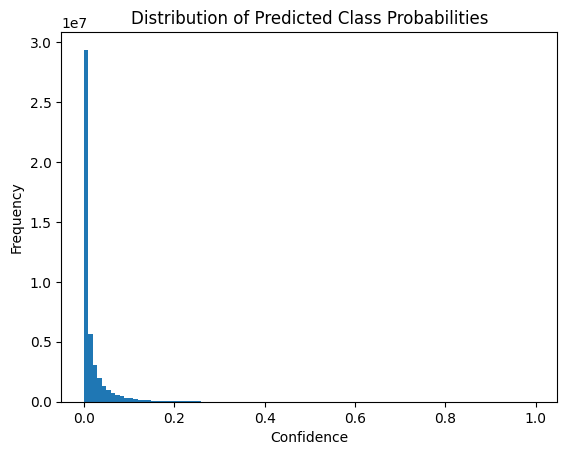

In [36]:
all_probs = pd.read_csv(cfg.pseudo_spectrograms_metadata_path)[[c for c in pd.read_csv(cfg.pseudo_spectrograms_metadata_path).columns if c.startswith("class_")]]
all_probs.values.flatten()

plt.hist(all_probs.values.flatten(), bins=100)
plt.title("Distribution of Predicted Class Probabilities")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()
